In [20]:
import numpy as np 
import os 
import sys
#sys.path.insert(1, '/its/home/drs25/Documents/GitHub/Quadruped/Code')
sys.path.insert(1, '/its/home/drs25/Quadruped/Code')
sys.path.insert(1, 'C:/Users/dexte/Documents/GitHub/Quadruped/Code')
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle 
from environment import *
from CPG import *
directory="/its/home/drs25/Quadruped/models/F2_Friction/" #noclipsin #updated_test #shitn # fitnessexpupdate #F2_Friction
from IPython.display import clear_output

## Load in the data from one folder and sort characteristics

In [21]:
#go into folder
files = [f for f in os.listdir(directory)
         if os.path.isfile(os.path.join(directory, f))]

dictionary={}
#list file types
for file in files:
    unique=file.replace("genotypes","").replace("history","").replace("fitnesses","").replace(".npy","").replace(".pkl","")
    details=file.split("_")
    if dictionary.get(unique,False)==False:
        dictionary[unique]={}
    dictionary[unique]["dt"]=float(details[1].replace("dt",""))
    dictionary[unique]["trial"]=int(details[3])
    dictionary[unique]["friction"]=float(details[4].replace("friction","").replace(".npy","").replace(".pkl",""))
    if len(details)>5:
        dictionary[unique]["Fitness"]=details[5].replace(".npy","").replace(".pkl","")
#gather information
def gather_by_friction(data,friction):
    fitnesses=[]
    genotypes=[]
    history=[]
    for key in data:
        details=data[key]
        if details['friction']==friction:
            fitnesses.append(np.load(directory+"fitnesses"+key+".npy"))
            history.append(np.load(directory+"history"+key+".npy"))
            genotypes.append(directory+"genotypes"+key+".pkl")
    return fitnesses,history,genotypes
def gather_by_trial(data,trial):
    fitnesses=[]
    genotypes=[]
    history=[]
    for key in data:
        details=data[key]
        if details['trial']==trial:
            fitnesses.append(np.load(directory+"fitnesses"+key+".npy"))
            history.append(np.load(directory+"history"+key+".npy"))
            genotypes.append(directory+"genotypes"+key+".pkl")
    return fitnesses,history,genotypes 
def gather_by_fitness(data,fitness):
    fitnesses=[]
    genotypes=[]
    history=[]
    for key in data:
        details=data[key]
        if details['Fitness']==fitness:
            fitnesses.append(np.load(directory+"fitnesses"+key+".npy"))
            history.append(np.load(directory+"history"+key+".npy"))
            genotypes.append(directory+"genotypes"+key+".pkl")
    return fitnesses,history,genotypes 
def gather_all(data):
    fitnesses=[]
    genotypes=[]
    history=[]
    for key in data:
        details=data[key]
        fitnesses.append(np.load(directory+"fitnesses"+key+".npy"))
        history.append(np.load(directory+"history"+key+".npy"))
        genotypes.append(directory+"genotypes"+key+".pkl")
    return fitnesses,history,genotypes


def gather_histories(genotypes,fitnesses):
    histories=[]
    for i in range(len(genotypes)):
        try:
            best_geno=np.argmax(fitnesses[i])
            with open(genotypes[i], 'rb') as f:
                population = pickle.load(f)
            histories.append(population[best_geno])
        except EOFError:
            print("error loading... corruption")
            histories.append(None)
    return histories
def gather_trajectories(cpgs,friction=0.5):
    traj=[]
    for i in range(len(cpgs)):
        clear_output(wait=True)
        print(i,"/",len(cpgs))
        env=environment(0,friction=friction)
        fit,hist,photos=env.runTrial(cpgs[i],100,delay=0) #uses a default fitness
        traj.append(hist['positions'])
    return traj
def gather_o_w(cpgs):
    outputs=[]
    omega=[]
    motors=[]
    for i in range(len(cpgs)):
        o=[]
        w=[]
        m=[]
        clear_output(wait=True)
        print(i,"/",len(cpgs))
        for step in range(1000):
            motor=cpgs[i].get_positions(np.array([0,0,0]))#env.runTrial(cpgs[i],100,delay=0) #uses a default fitness
            o.append(cpgs[i].outputs[0:3])
            w.append(cpgs[i].omega)
            m.append(motor)
        outputs.append(o)
        omega.append(w)
        motors.append(m)
    return np.array(outputs),np.array(omega),np.array(motors)

def get_grid(minx, maxx, miny, maxy, pixels_per_meter=100):
    width_m  = maxx - minx
    height_m = maxy - miny
    width_px  = int(np.ceil(width_m * pixels_per_meter))
    height_px = int(np.ceil(height_m * pixels_per_meter))
    x = np.linspace(minx, maxx, width_px)
    y = np.linspace(miny, maxy, height_px)
    xx, yy = np.meshgrid(x, y)
    squares = (np.floor(xx) + np.floor(yy)) % 2
    # PyBullet-like colors
    light = np.array((1, 1, 1))
    dark  = np.array((180/255, 202/255, 237/255))

    rgb = np.zeros((height_px, width_px, 3))
    rgb[squares == 0] = light
    rgb[squares == 1] = dark
    return rgb
def get_bounds(trajectories):
    """
    trajectories: list of arrays of shape (Ti, 2)
    """

    minx = np.inf
    maxx = -np.inf
    miny = np.inf
    maxy = -np.inf

    for traj in trajectories:
        minx = min(minx, traj[:, 0].min())
        maxx = max(maxx, traj[:, 0].max())
        miny = min(miny, traj[:, 1].min())
        maxy = max(maxy, traj[:, 1].max())

    return minx, maxx, miny, maxy

f,h,g=gather_by_friction(dictionary,0.5)
cpgs=gather_histories(g,f)
o,w,m=gather_o_w(cpgs)
#trajs=gather_trajectories(cpgs)]


1 / 2


## plot history information

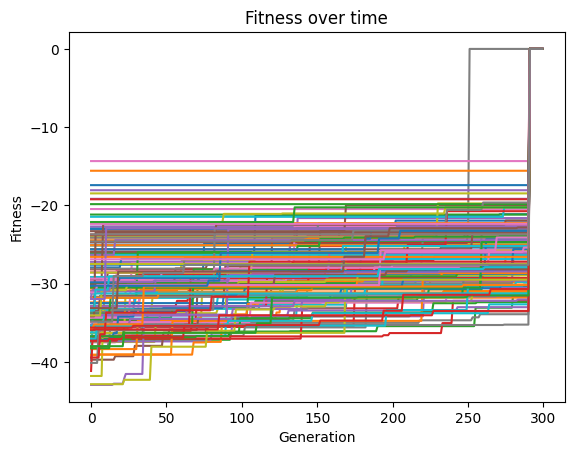

In [22]:
# look at average fitness
f,h,g=gather_all(dictionary)
for i in range(len(h)):
    plt.plot(h[i])
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over time")
plt.show()

In [23]:
# look at top trajectories
"""f,h,g=gather_all(dictionary)
cpgs=gather_histories(g,f)
trajs=gather_trajectories(cpgs)
minx, maxx, miny, maxy=get_bounds(trajs)
grid = get_grid(minx, maxx, miny, maxy, 100)

plt.imshow(
    grid,
    extent=[minx*100, maxx*100, miny*100, maxy*100],
    origin="lower"
)
for i in range(len(trajs)):
    traj=np.array(trajs[i])*100
    plt.plot(traj[:,0],traj[:,1])
plt.ylabel("Y position (cm)")
plt.xlabel("X position (cm)")
plt.title("Trajectories of best CPGs")
plt.show()"""

'f,h,g=gather_all(dictionary)\ncpgs=gather_histories(g,f)\ntrajs=gather_trajectories(cpgs)\nminx, maxx, miny, maxy=get_bounds(trajs)\ngrid = get_grid(minx, maxx, miny, maxy, 100)\n\nplt.imshow(\n    grid,\n    extent=[minx*100, maxx*100, miny*100, maxy*100],\n    origin="lower"\n)\nfor i in range(len(trajs)):\n    traj=np.array(trajs[i])*100\n    plt.plot(traj[:,0],traj[:,1])\nplt.ylabel("Y position (cm)")\nplt.xlabel("X position (cm)")\nplt.title("Trajectories of best CPGs")\nplt.show()'

147 / 148


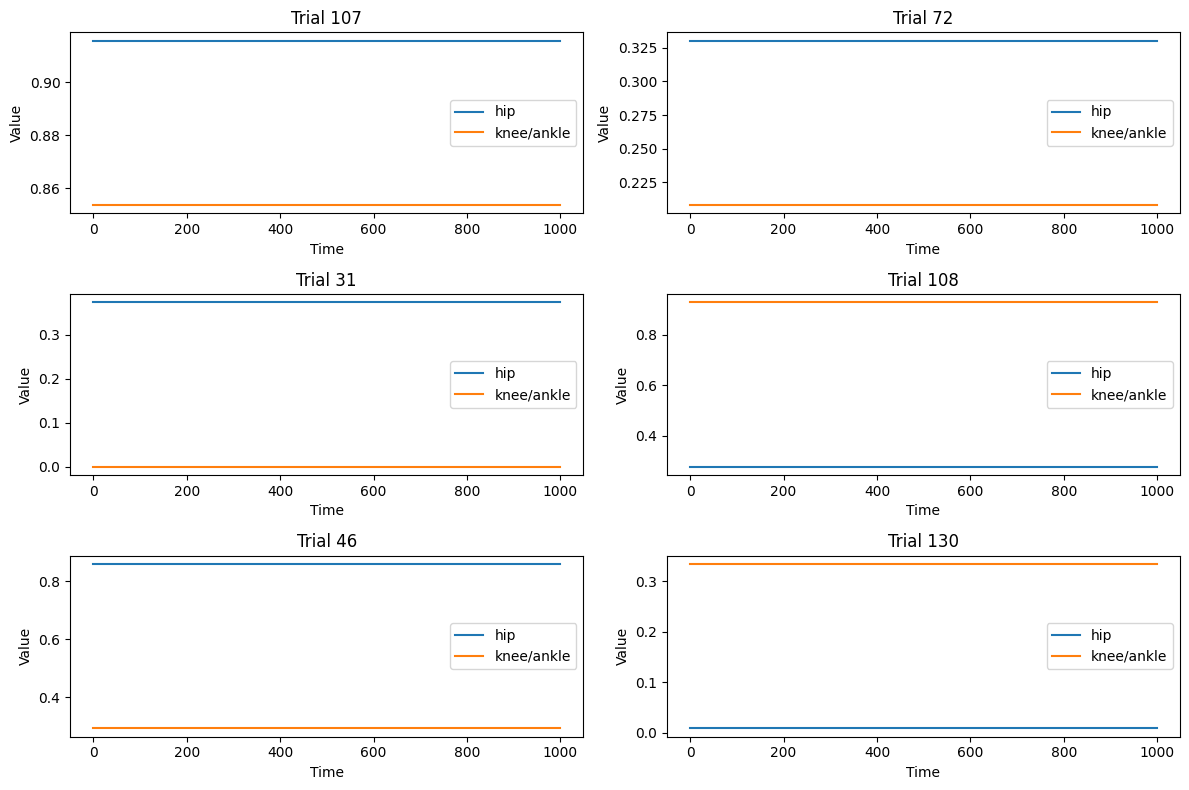

In [24]:
# Look at omega and outputs
f,h,g=gather_all(dictionary)
cpgs=gather_histories(g,f)
o,w,m=gather_o_w(cpgs)

n_plots = 6
time = o.shape[1]
try:
    trial_idxs = np.random.choice(o.shape[0], n_plots, replace=False)
except:
    trial_idxs = [0,0,0,0,0,0]

fig, axes = plt.subplots(3, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, idx in zip(axes, trial_idxs):
    ax.plot(o[idx, :, 0], label="hip")
    ax.plot(o[idx, :, 1], label="knee/ankle")
    ax.set_title(f"Trial {idx}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.legend()

plt.tight_layout()
plt.show()

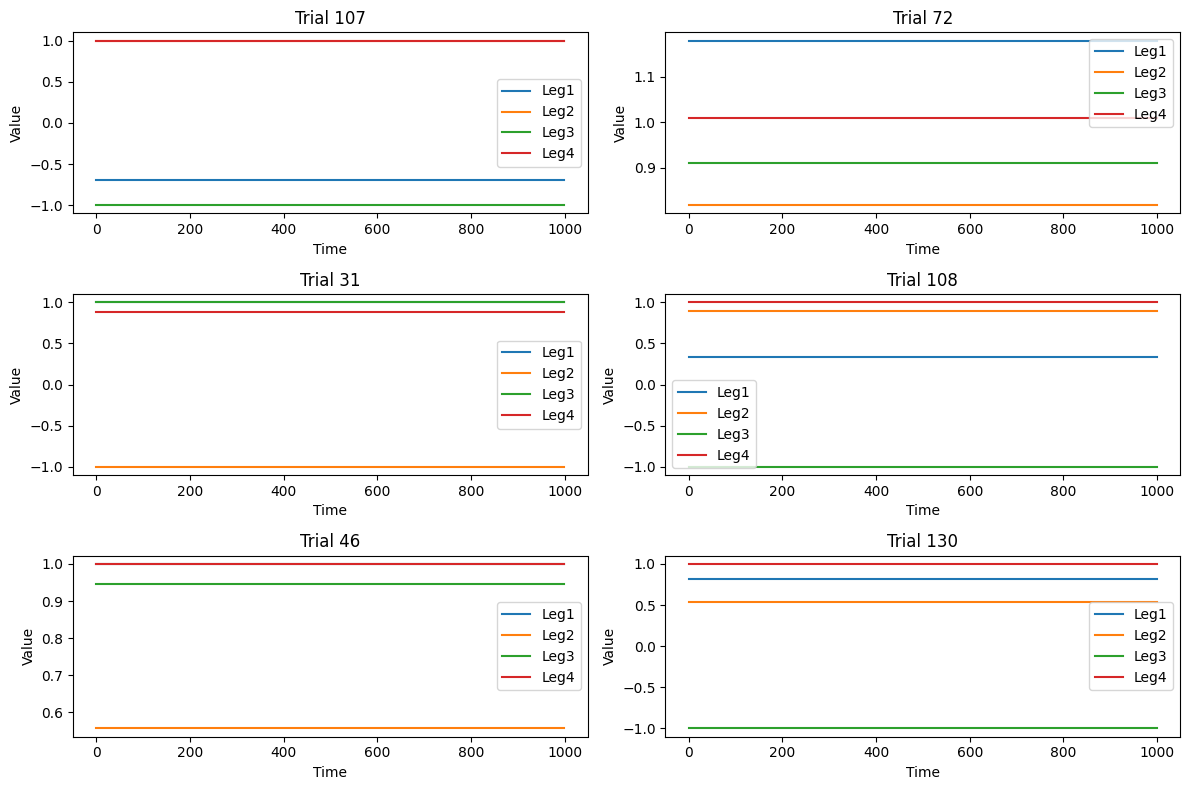

In [25]:

n_plots = 6
time = w.shape[1]

fig, axes = plt.subplots(3, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, idx in zip(axes, trial_idxs):
    ax.plot(w[idx, :, 0], label="Leg1")
    ax.plot(w[idx, :, 1], label="Leg2")
    ax.plot(w[idx, :, 2], label="Leg3")
    ax.plot(w[idx, :, 3], label="Leg4")
    ax.set_title(f"Trial {idx}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.legend()

plt.tight_layout()
plt.show()

(148, 1000, 12)


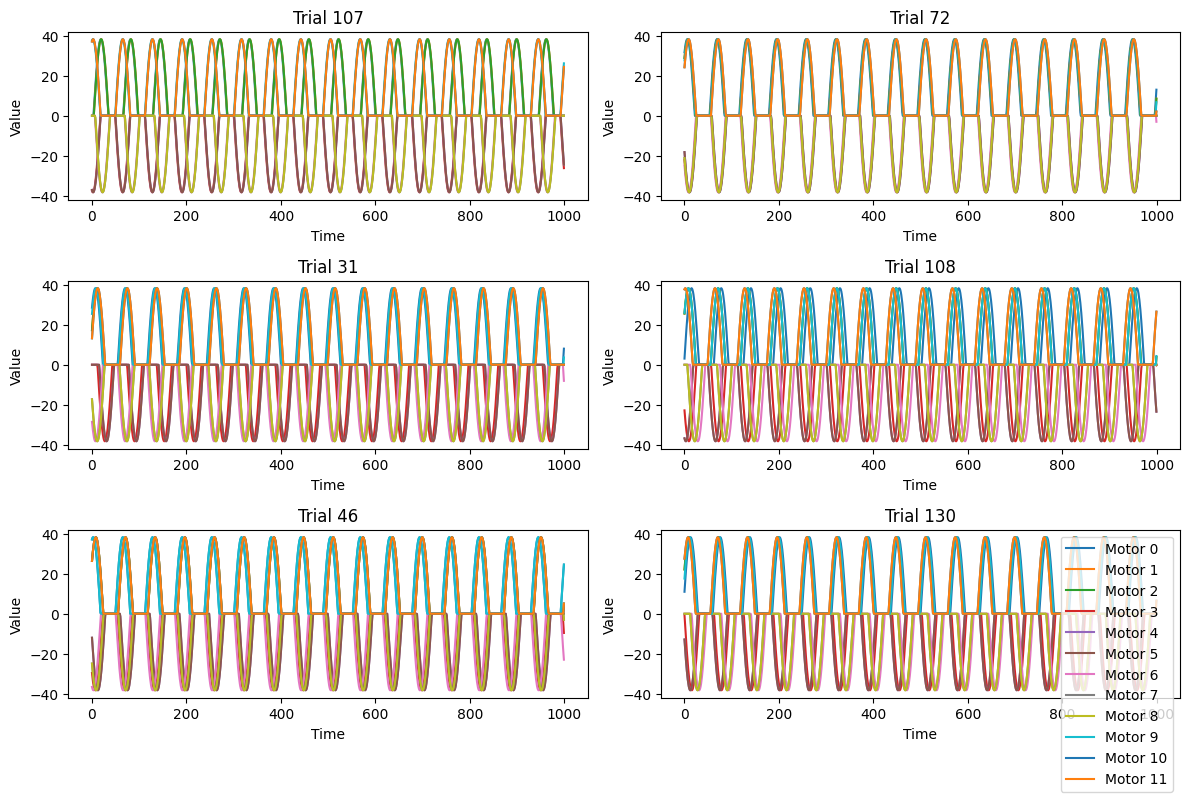

In [26]:

n_plots = 6
time = m.shape[1]
print(m.shape)
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, idx in zip(axes, trial_idxs):
    for i in range(12):
        ax.plot(m[idx, :, i], label="Motor "+str(i))
    ax.set_title(f"Trial {idx}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")

ax.legend()

plt.tight_layout()
plt.show()

## Fitness comparison

/tmp/ipykernel_2707513/1107838039.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


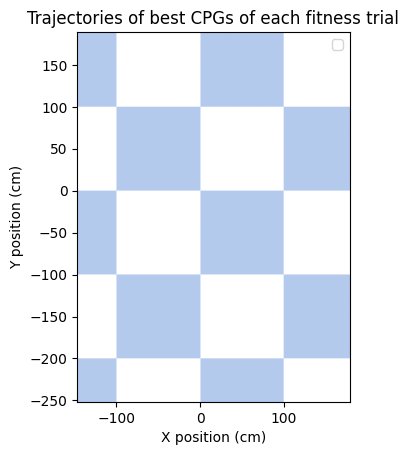

In [27]:
# look at top trajectories
grid = get_grid(minx, maxx, miny, maxy, 100)
plt.imshow(
    grid,
    extent=[minx*100, maxx*100, miny*100, maxy*100],
    origin="lower"
)
fitnesses=["F1","F2","F3"]
colours=["g","r","b"]
linestyle=[None,"--",":"]
symbols=[r"$\xi$",r"$\varrho$",r"$\varpi$"]
for j in range(3):
    f,h,g=gather_by_fitness(dictionary,fitnesses[j])
    cpgs=gather_histories(g,f)
    trajs=gather_trajectories(cpgs)
    #minx, maxx, miny, maxy=get_bounds(trajs)
    for i in range(len(trajs)):
        traj=np.array(trajs[i])*100
        if i==0:
            plt.plot(traj[:,0],traj[:,1],c=colours[j],linestyle=linestyle[j],label=symbols[j])
        else: plt.plot(traj[:,0],traj[:,1],c=colours[j],linestyle=linestyle[j])
plt.ylabel("Y position (cm)")
plt.xlabel("X position (cm)")
plt.title("Trajectories of best CPGs of each fitness trial")
plt.legend(loc="upper right")
plt.savefig("/its/home/drs25/Quadruped/assets/plots/fitnesses_new.pdf")
plt.show()

## Retrial and gather from step function the values

1 / 2


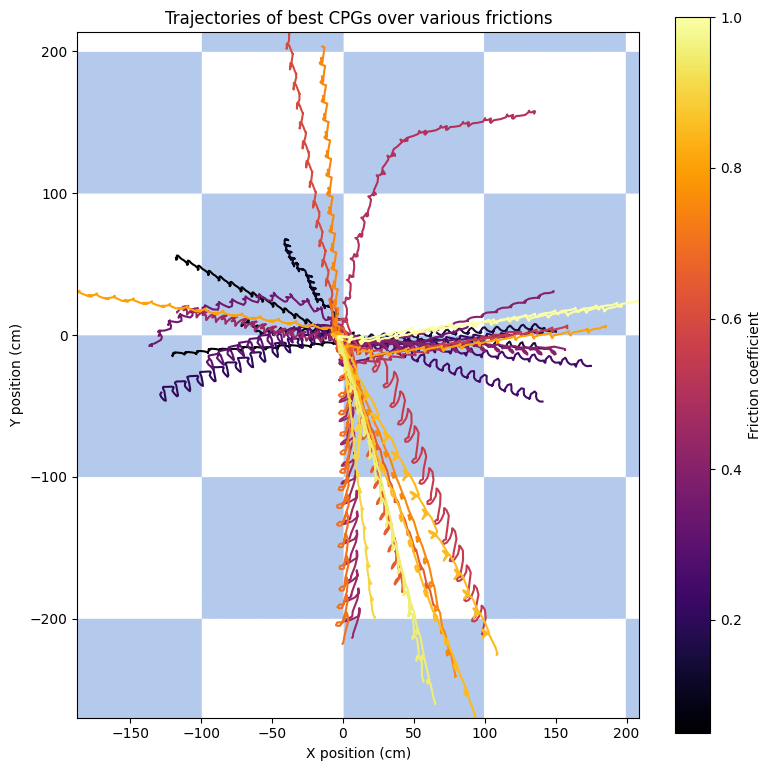

In [29]:
frictions=[]
for key in dictionary:
    if dictionary[key]['friction']<=1:
        frictions.append(dictionary[key]['friction'])

frictions = np.sort(np.unique(np.array(frictions)))

trajs_=[]
minx, maxx, miny, maxy = 0,0,0,0

for i in range(len(frictions)):
    f,h,g = gather_by_friction(dictionary, frictions[i])
    cpgs = gather_histories(g,f)
    trajs = gather_trajectories(cpgs,friction=frictions[i])

    minx_, maxx_, miny_, maxy_ = get_bounds(trajs)
    minx = min(minx, minx_)
    miny = min(miny, miny_)
    maxx = max(maxx, maxx_)
    maxy = max(maxy, maxy_)

    trajs_.append(trajs)

grid = get_grid(minx, maxx, miny, maxy, 100)

cmap = plt.cm.inferno          # or plasma, inferno, turbo
norm = mpl.colors.Normalize(
    vmin=frictions.min(),
    vmax=frictions.max()
)

plt.figure(figsize=(8, 8))

plt.imshow(
    grid,
    extent=[minx*100, maxx*100, miny*100, maxy*100],
    origin="lower",
)

for i in range(len(trajs_)):
    trajs = trajs_[i]
    color = cmap(norm(frictions[i]))

    for traj in trajs:
        traj = np.array(traj) * 100
        plt.plot(
            traj[::4,0],
            traj[::4,1],
            color=color,
            linewidth=1.5
        )

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label("Friction coefficient")

plt.ylabel("Y position (cm)")
plt.xlabel("X position (cm)")
plt.title("Trajectories of best CPGs over various frictions")

plt.tight_layout()
plt.savefig("/its/home/drs25/Quadruped/assets/plots/frictions_evolved_new.pdf")
plt.show()

### same gait over various frictions

1 / 2


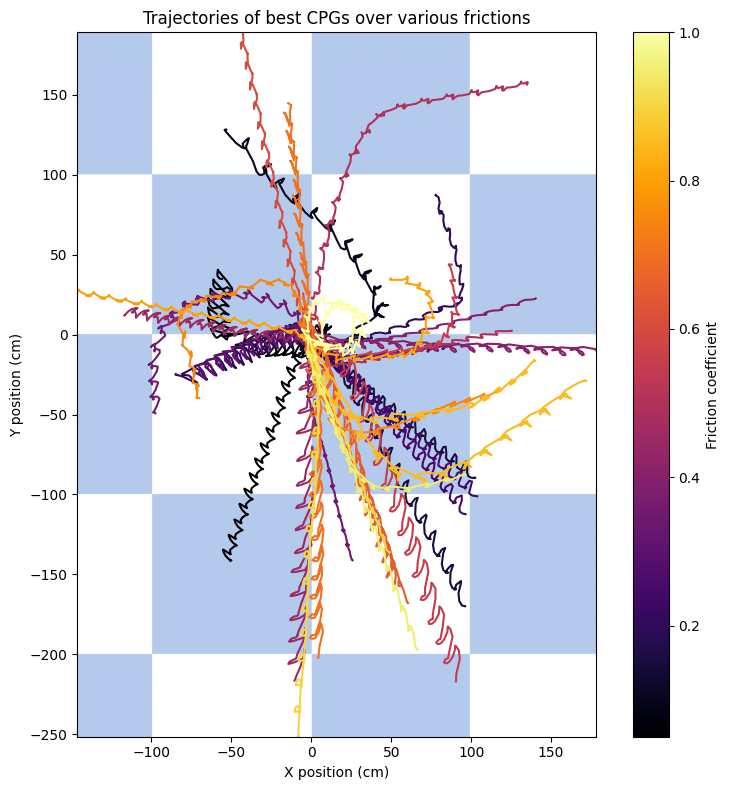

In [34]:
# code to simulate this

#pick middle friction and best fitness
f,h,g=gather_by_friction(dictionary,0.5)
cpgs=gather_histories(g,f)
cpgs=[cpgs[0] for i in range(len(np.arange(0.05,1,0.05)))]

trajs_=[]
minx, maxx, miny, maxy = 0,0,0,0

for i in range(len(frictions)):
    f,h,g = gather_by_friction(dictionary, frictions[i])
    cpgs = gather_histories(g,f)
    #cpgs=[cpgs[0]]
    trajs = gather_trajectories(cpgs,friction=0.5)

    minx_, maxx_, miny_, maxy_ = get_bounds(trajs)
    minx = min(minx, minx_)
    miny = min(miny, miny_)
    maxx = max(maxx, maxx_)
    maxy = max(maxy, maxy_)

    trajs_.append(trajs)

grid = get_grid(minx, maxx, miny, maxy, 100)

cmap = plt.cm.inferno          # or plasma, inferno, turbo
norm = mpl.colors.Normalize(
    vmin=frictions.min(),
    vmax=frictions.max()
)

plt.figure(figsize=(8, 8))

plt.imshow(
    grid,
    extent=[minx*100, maxx*100, miny*100, maxy*100],
    origin="lower",
)

for i in range(len(trajs_)):
    trajs = trajs_[i]
    color = cmap(norm(frictions[i]))

    for traj in trajs:
        traj = np.array(traj) * 100
        plt.plot(
            traj[::3,0],
            traj[::3,1],
            color=color,
            linewidth=1.5
        )

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label("Friction coefficient")

plt.ylabel("Y position (cm)")
plt.xlabel("X position (cm)")
plt.title("Trajectories of best CPGs over various frictions")

plt.tight_layout()
plt.savefig("/its/home/drs25/Quadruped/assets/plots/frictions_unevolved_new.pdf")
plt.show()
